In [1]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.gridspec as gridspec #Customizing Figure Layouts https://matplotlib.org/3.2.1/tutorials/intermediate/gridspec.html
import matplotlib.pyplot as plt
import metpy.calc as mpcalc  #https://unidata.github.io/MetPy/latest/api/generated/metpy.calc.html
import numpy as np
import xarray as xr

PROJ: proj_create_from_database: Cannot find proj.db


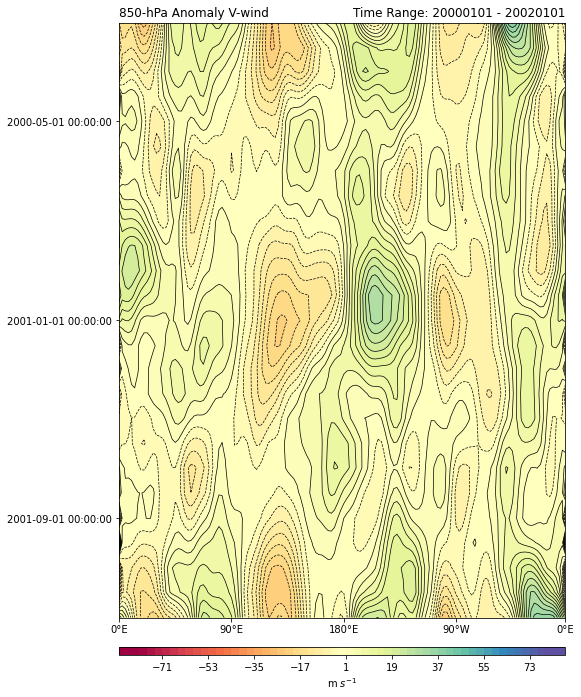

In [3]:
#create time slice from dates
start_time = '2000-01-01'           #my not-real birthday:)))
end_time = '2002-01-01'             #2 years later

#parameter and level
param = 'vwnd'
level = 850

#dataset via xarray
ds = xr.open_dataset(('vwnd.mon.mean.nc'.format(param, start_time[:4])))

#create slice variables subset domain
time_slice = slice(start_time, end_time)
lat_slice = slice(60, 40)
lon_slice = slice(0, 360)

#get data, selecting time, level, lat/lon slice
data = ds[param].sel(time=time_slice,
                     level=level,
                     lat=lat_slice,
                     lon=lon_slice)

# Compute weights and take weighted average over latitude dimension
weights = np.cos(np.deg2rad(data.lat.values))
avg_data = (data * weights[None, :, None]).sum(dim='lat') / np.sum(weights)
anom_data = (data * weights[None, :, None]).sum(dim='lat') - avg_data
# Get times and make array of datetime objects
vtimes = data.time.values.astype('datetime64[ms]').astype('O')

# Specify longitude values for chosen domain
lons = data.lon.values
# Start figure
fig = plt.figure(figsize=(8,16))

# Use gridspec to help size elements of plot; small top plot and big bottom plot
gs = gridspec.GridSpec(nrows=2, ncols=1, height_ratios=[1, 6], hspace=0.03)

# Tick labels
x_tick_labels = [u'0\N{DEGREE SIGN}E', u'90\N{DEGREE SIGN}E',
                 u'180\N{DEGREE SIGN}E', u'90\N{DEGREE SIGN}W',
                 u'0\N{DEGREE SIGN}E']


ax = fig.add_subplot(gs[1, 0])
ax.invert_yaxis()  # Reverse the time order to do oldest first

# Plot of chosen variable averaged over latitude and slightly smoothed
clevs = np.arange(-80, 81, 3)
cf = ax.contourf(lons, vtimes, mpcalc.smooth_n_point(anom_data, 9, 2), clevs, cmap=plt.cm.Spectral, extend='both')
cs = ax.contour(lons, vtimes, mpcalc.smooth_n_point(anom_data, 9, 2), clevs, colors='k', linewidths=0.7)
cbar = plt.colorbar(cf, orientation='horizontal', pad=0.04, aspect=50, extendrect=True)
cbar.set_label('m $s^{-1}$')

# Make some ticks and tick labels
ax.set_xticks([0, 90, 180, 270, 357.5])
ax.set_xticklabels(x_tick_labels)
ax.set_yticks(vtimes[4::8])
ax.set_yticklabels(vtimes[4::8])

# Set some titles
plt.title('850-hPa Anomaly V-wind', loc='left', fontsize=12)
plt.title('Time Range: {0:%Y%m%d} - {1:%Y%m%d}'.format(vtimes[0], vtimes[-1]),
          loc='right', fontsize=12)

plt.show()